#CNN Multi-Output basada en la arquitectura U-Net

Como proyecto se propone diseñar una red neuronal convolucional que a partir de la arquitectura U-Net determine dos salidas, que sean distintas desde lo conceptual o lo funcional.
Como ejemplo de esto, se utiliza un Conjunto de datos obtenido del repositorio Kaggle

https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation



El mismo posee una serie de imágenes de radiografías de tórax, las mismas están clasificadas según si corresponde con que el paciente tenga tuberculosis o sea un pulmón “Normal”.
Además, a cada imagen, le corresponde una imagen “máscara” que representa la segmentación semántica.
A partir de estos datos, se busca desarrollar una CNN basada en la arquitectura U-Net que partiendo de la radiografía, genere la segmentación semántica y la clasificación correspondiente a las categorías del entrenamiento  


Se cree que el entrenamiento de dicha CNN, se verá atravesado por la lucha entre ambos criterios de entrenamiento(la clasificación y la segmentación), por ende se quiere ver cómo esto se va acomodando a medida que avanza el entrenamiento

In [ ]:
import numpy as np
import pandas as pd
import sklearn.model_selection as skl_model_selection
import cv2


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2DTranspose, Conv2D, Input, BatchNormalization, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import  ReduceLROnPlateau

import kagglehub
import os

import matplotlib.pyplot as plt



##Obtención y preprocesamiento de los datos

Una vez que se obtuvieron los datos desde el repositorio, se obtuvieron los id’s y los labels correspondientes, Además se generaron los objetos que permiten obtener y procesar los batch de procesamiento de las imágenes, administrando los correspondientes targets y labels


In [ ]:
dataset_path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/iamtapendu/chest-x-ray-lungs-segmentation/versions/1


In [ ]:
#Vamos a intentar obtener las imagenes, para eso primero debemos obtener la tabla


metadata = pd.read_csv(os.path.join(dataset_path, "MetaData.csv"))
metadata.head()

dataset_ids = metadata["id"]
dataset_label = metadata["ptb"]

dataset_ids = np.array(dataset_ids)
dataset_label = np.array(dataset_label)


In [ ]:
def get_image_and_mask(id, dataset_path, target_size):
  img_path = f"{dataset_path}/Chest-X-Ray/Chest-X-Ray/image/{id}.png"
  mask_path = f"{dataset_path}/Chest-X-Ray/Chest-X-Ray/mask/{id}.png"

  img = load_img(path=img_path, color_mode="grayscale", target_size=target_size)
  mask_img = load_img(path= mask_path, color_mode="grayscale", target_size=target_size)

  img_array = img_to_array(img)
  mask_array = img_to_array(mask_img)

  img_array /=255
  mask_array /=255
  return img_array, mask_array

In [ ]:
class ImageMaskGenerator(Sequence):
  def __init__(self, dataset_ids, dataset_label, dataset_path, batch_size=32, target_size=(224, 224), **kwargs):
    super().__init__(**kwargs)
    self.dataset_ids = dataset_ids
    self.dataset_label = dataset_label
    self.dataset_path = dataset_path
    self.batch_size = batch_size
    self.target_size = target_size
    self.indexes = np.arange(len(self.dataset_ids))

  def __len__(self):
    return int(np.floor(len(self.dataset_ids) / self.batch_size))

  def __getitem__(self, index):
    batch_ids = self.dataset_ids[index * self.batch_size: (index + 1) * self.batch_size]
    images = []
    mask = []
    labels = []
    for id in batch_ids:
      img_path = f"{self.dataset_path}/Chest-X-Ray/Chest-X-Ray/image/{id}.png"
      mask_path = f"{self.dataset_path}/Chest-X-Ray/Chest-X-Ray/mask/{id}.png"

      img = load_img(path=img_path, color_mode="grayscale", target_size=self.target_size)
      mask_img = load_img(path= mask_path, color_mode="grayscale", target_size=self.target_size)

      img_array = img_to_array(img)
      mask_array = img_to_array(mask_img)

      img_array /=255
      mask_array /=255

      label = self.get_classification_label(id)

      images.append(img_array)
      mask.append(mask_array)
      labels.append(label)

    return np.array(images), { "segmentation": np.array(mask), "classification": np.array(labels)}

  def get_classification_label(self, id):
    ind = np.where(self.dataset_ids == id)[0][0]
    return self.dataset_label[ind]

  def on_epoch_end(self):
    np.random.shuffle(self.indexes)




In [ ]:
#Separo los conjuntos
train_id, val_id, train_label, val_label = skl_model_selection.train_test_split(dataset_ids, dataset_label, shuffle=True, test_size=0.2, random_state=42)




In [ ]:
batch_size = 16
train_generator = ImageMaskGenerator(train_id, train_label, dataset_path, batch_size=batch_size)
val_generator = ImageMaskGenerator(val_id, val_label, dataset_path, batch_size=batch_size)

###Funciones auxiliares
Se prepararon funciones que permiten renderizar y mostrar una tira de imágenes, con la imagen original, la máscara target, ambas combinadas con cierto nivel de transparencia, lo mismo para cuando se quieren visualizar las predicciones


In [1]:
#Visualizando algunas imagenes
def get_expand_image(image):
    img = image.copy()
    # img = np.expand_dims(img, axis=-1)
    img = np.repeat(img, 3, axis=-1)
    return img

def get_colored_mask_in_image(image, mask, color=[0., 0., 255.], alpha=.4):
    local_image = get_expand_image(image)
    mask = mask.squeeze(axis=-1)
    colored = np.zeros_like(local_image)
    colored[mask > .5] = color

    return cv2.addWeighted(local_image, 1 - alpha, colored, alpha, 0)

def show_line_image(image, target, label):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))


    ax[0].imshow(image * 255, cmap='binary_r')
    ax[0].set_title(f"Image {label}")

    ax[1].imshow(target * 255, cmap='binary_r')
    ax[1].set_title(f"Target {label}")

    ax[2].imshow(get_colored_mask_in_image(image, target))
    ax[2].set_title(f"Combined {label}")

    plt.show()

def show_line_comparative_image(image, target, predicted):
    fig, ax = plt.subplots(1, 5, figsize=(10, 4))

    ax[0].imshow(image * 255, cmap='binary_r')
    ax[0].set_title(f"Original")

    ax[1].imshow(target * 255, cmap='binary_r')
    ax[1].set_title(f"Target")

    ax[2].imshow(get_colored_mask_in_image(image, target))
    ax[2].set_title(f"Combinado target")


    ax[3].imshow(predicted * 255, cmap='binary_r')
    ax[3].set_title(f"Predición")

    ax[4].imshow(get_colored_mask_in_image(image, predicted))
    ax[4].set_title(f"Combinado Predición")

    plt.show()


##Arquitectura
Para el diseño se implementa la U-Net, adicionando un clasificador en “la zona intermedia”, esa zona posterior a lo que podríamos llamar “codificador”, aunque sea conceptualmente incorrecto, en nuestra arquitectura pensarlo así, nos permite darle una explicación morfológica a nuestra red, entendiendo el proceso acumulado de convolución, pooling y batch normalization como una extraccion de caracteristicas, que tomara dos caminos, la clasificación y la generación de la máscara correspondiente


A para el clasificador, en este caso se implementa un global average pooling, una capa densa de 64 neuronas, un dropout y una capa densa que como el tipo de clasificación es binario, se utiliza como activación una sigmoidea

In [ ]:
def codingUNetStep(input, filters, withPooling= True ):
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(input)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(conv)
  conv = BatchNormalization()(conv)
  pool = None
  if(withPooling == True):
    pool = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv)
  return conv, pool

def decodingUNetStep(input, filters, concatenateInput):
  up = Conv2DTranspose(filters, (2, 2), strides=(2,2), padding="same")(input)
  merge = concatenate([up, concatenateInput], axis=3)
  conv = Conv2D(filters, (3,3), activation = 'relu', padding = 'same')(merge)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(conv)
  conv = BatchNormalization()(conv)
  return conv

def codingUNet(input):
  conv1, pool1 = codingUNetStep(input, 64)
  conv2, pool2 = codingUNetStep(pool1, 128)
  conv3, pool3 = codingUNetStep(pool2, 256)
  conv4, _ = codingUNetStep(pool3, 512, False)
  return conv1, conv2, conv3, conv4

def decodingUNet(input,conv1, conv2, conv3):

  conv = decodingUNetStep(input, 256, conv3)
  conv = decodingUNetStep(conv, 128, conv2)
  conv = decodingUNetStep(conv, 64, conv1)
  return conv



In [ ]:


def generateModel(input_shape):

  input = Input(shape=input_shape)

  conv1, conv2, conv3, conv4 = codingUNet(input)

  segmentation = decodingUNet(conv4, conv1, conv2, conv3)
  segmentation = Conv2D(1, (1, 1), activation="sigmoid", name="segmentation")(segmentation)

  classification = GlobalAveragePooling2D()(conv4)
  classification = Dense(64, activation='relu')(classification)
  classification = Dropout(0.2)(classification)
  classification = Dense(1, activation='sigmoid', name="classification")(classification)



  model = keras.Model(inputs=[input], outputs={
      "segmentation": segmentation,
      "classification": classification,
      })

  model.compile(
      optimizer=Adam(),
      loss={
          "segmentation": "binary_crossentropy",
          "classification": "binary_crossentropy",
          },
      metrics={
          "segmentation": "accuracy",
          "classification": "accuracy",
          }
  )

  return model


model = generateModel((224,224,1))



model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 224, 224, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 224, 224, 64)   │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 224, 224, 64)   │            256 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 112, 112, 64)   │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 112, 112, 128)  │            512 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 112, 112, 128)  │            512 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 56, 56, 128)    │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 56, 56, 256)    │          1,024 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 56, 56, 256)    │        590,080 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 56, 56, 256)    │          1,024 │ conv2d_61[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,740,354 (29.53 MB)

 Trainable params: 7,734,722 (29.51 MB)

 Non-trainable params: 5,632 (22.00 KB)

###Funciones auxiliares

Se implementan funciones que permiten almacenar el historial de entrenamiento, renderizar imágenes probando el modelo, graficar la evolución de la precisión, entre otras herramientas auxiliares

In [ ]:
#View Validation data
def get_dataset_item(index, dataset, label):
  id = dataset[index]
  image, mask = get_image_and_mask(id, dataset_path, (224, 224))
  return image, mask, label[index]


def view_val_examples(model, size):
  view_dataset = []

  for i in range(size):
    image, expected_mask, expected_label = get_dataset_item(i, val_id, val_label)
    view_dataset.append((image, expected_mask, expected_label))

  for (image, mask, label) in view_dataset:
    image = np.expand_dims(image, axis=0)
    predicted = model.predict(image, batch_size=1)
    show_line_comparative_image(image[0], mask, predicted["segmentation"][0])


In [ ]:
#History Operations

def showAccuracyGraph(classification_acc, segmentation_acc, val_classification_acc, val_segmentation_acc):
  fig, ax = plt.subplots(figsize=(9, 4))
  ax.plot(classification_acc, label="Classification Train Accuracy", c='r', linestyle='--')
  ax.plot(segmentation_acc, label="Segmentation Train Accuracy", c='b', linestyle='--')
  ax.plot(val_classification_acc, label="Classification Validation Accuracy", c='r', linestyle='-')
  ax.plot(val_segmentation_acc, label="Segmentation Validation Accuracy", c='b', linestyle='-')
  ax.set_title("Accuracy")
  ax.legend()
  ax.grid()
  plt.show()

def showCompleteHistory():
  history = pd.read_csv("./history.csv")
  classification_acc = history["classification_accuracy"]
  val_classification_acc = history["val_classification_accuracy"]
  segmentation_acc = history["segmentation_accuracy"]
  val_segmentation_acc = history["val_segmentation_accuracy"]
  showAccuracyGraph(classification_acc, segmentation_acc, val_classification_acc, val_segmentation_acc)

def addHistory(history):
  hist_df = pd.DataFrame(history.history)
  history = pd.read_csv("./history.csv")
  hist_df = pd.concat([history, hist_df])
  hist_df.to_csv("./history.csv")



##Entrenamiento

Se hacen 4 iteraciones de entrenamiento sumando un total de 50 épocas, controlando el progreso de los parámetros de control del modelo, analizando los cambios tanto en la pérdida como en la precisión o certeza.

In [ ]:
#Primera iteración
initial_epoch = 0
epochs = initial_epoch + 10

reduce_lr = ReduceLROnPlateau(
    monitor='val_segmentation_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
)

total_epochs = initial_epoch + epochs
model.save("./model-it-01.h5")

hist_df = pd.DataFrame(history.history)
hist_df.to_csv("./history.csv")

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - classification_accuracy: 0.5861 - classification_loss: 1.0028 - loss: 1.6027 - segmentation_accuracy: 0.7291 - segmentation_loss: 0.5999 - val_classification_accuracy: 0.5469 - val_classification_loss: 0.9852 - val_loss: 12.3466 - val_segmentation_accuracy: 0.2581 - val_segmentation_loss: 11.3614
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - classification_accuracy: 0.7579 - classification_loss: 0.5188 - loss: 0.7324 - segmentation_accuracy: 0.9331 - segmentation_loss: 0.2137 - val_classification_accuracy: 0.5469 - val_classification_loss: 1.1954 - val_loss: 40.6771 - val_segmentation_accuracy: 0.2900 - val_segmentation_loss: 39.4817
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - classification_accuracy: 0.7883 - classification_loss: 0.4556 - loss: 0.6077 - segmentation_accuracy: 0.9492 - segmentation_loss: 0.1521 - val_classification_accuracy: 0.5469 - val_classification_loss: 0.7172 - val_loss: 53.6759 - val_segmentation

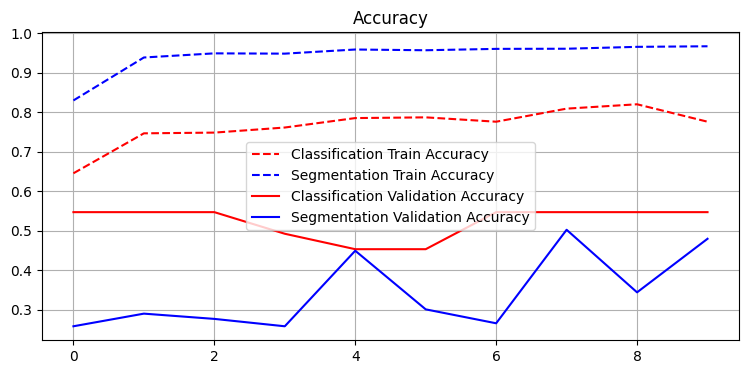

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


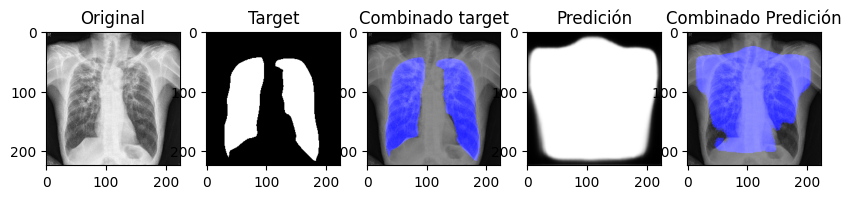

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


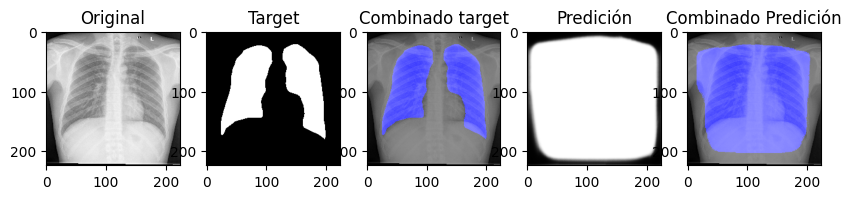

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


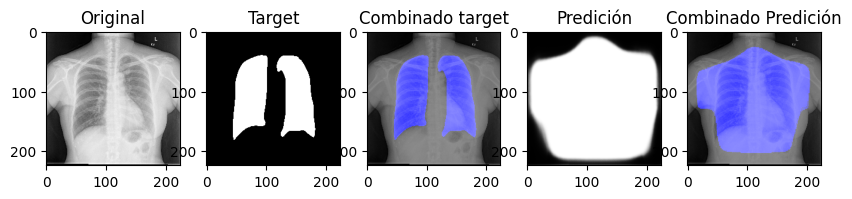

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


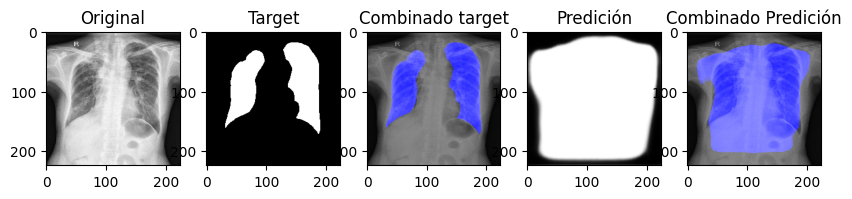

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


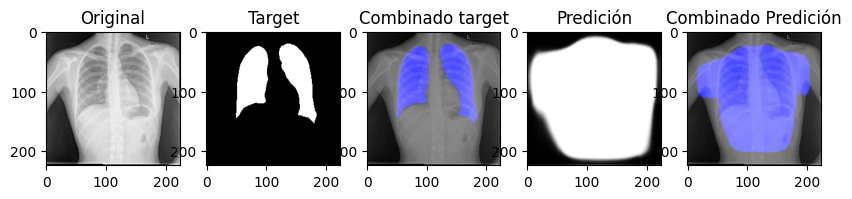

In [ ]:
showCompleteHistory()
view_val_examples(model,5)

Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - classification_accuracy: 0.7777 - classification_loss: 0.4402 - loss: 0.5420 - segmentation_accuracy: 0.9637 - segmentation_loss: 0.1018 - val_classification_accuracy: 0.5469 - val_classification_loss: 6.2515 - val_loss: 7.4632 - val_segmentation_accuracy: 0.7462 - val_segmentation_loss: 1.2117
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.8118 - classification_loss: 0.4108 - loss: 0.5266 - segmentation_accuracy: 0.9595 - segmentation_loss: 0.1158 - val_classification_accuracy: 0.5469 - val_classification_loss: 10.6039 - val_loss: 12.7187 - val_segmentation_accuracy: 0.7462 - val_segmentation_loss: 2.1149
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.7793 - classification_loss: 0.4789 - loss: 0.5704 - segmentation_accuracy: 0.9680 - segmentation_loss: 0.0915 - val_classification_accuracy: 0.5469 - val_classification_loss: 6.7003 - val_loss: 7.3978 - val_segmentation

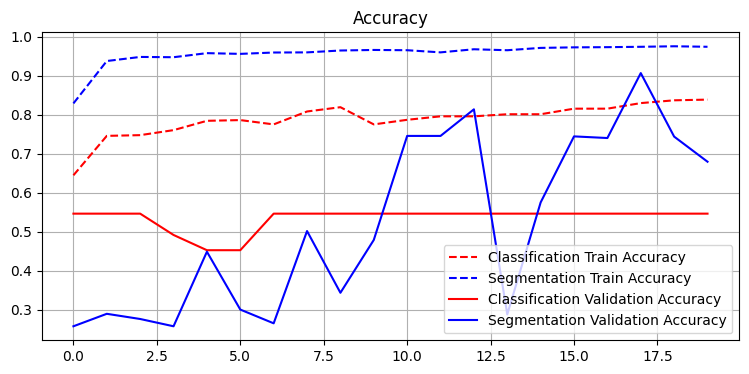

In [ ]:
#Segunda iteración
add_epochs = 10
epochs = total_epochs + add_epochs
initial_epoch = total_epochs

history = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
)

total_epochs += add_epochs

model.save("./model-it-02.h5")
addHistory(history)
showCompleteHistory()

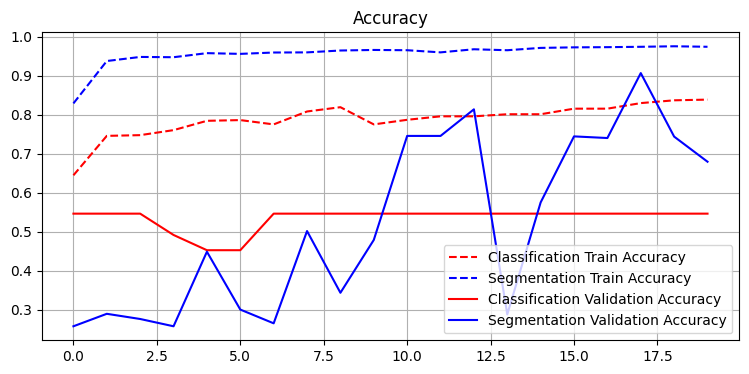

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


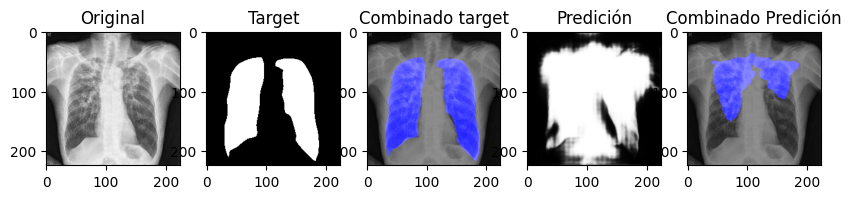

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


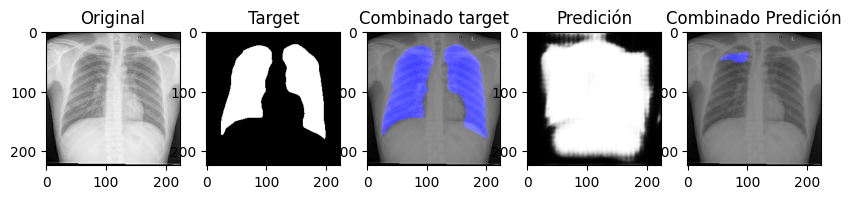

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


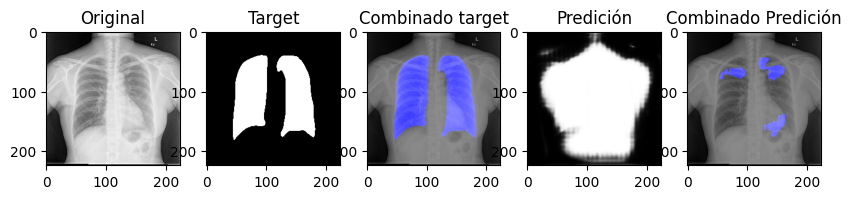

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


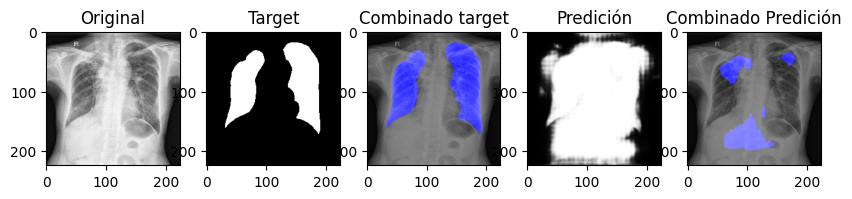

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


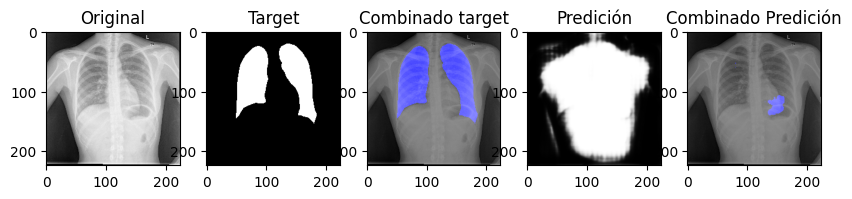

In [ ]:
showCompleteHistory()
view_val_examples(model,5)

Epoch 21/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - classification_accuracy: 0.8443 - classification_loss: 0.3545 - loss: 0.4185 - segmentation_accuracy: 0.9766 - segmentation_loss: 0.0640 - val_classification_accuracy: 0.5156 - val_classification_loss: 1.4825 - val_loss: 1.7881 - val_segmentation_accuracy: 0.9392 - val_segmentation_loss: 0.3056
Epoch 22/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.8462 - classification_loss: 0.3244 - loss: 0.3852 - segmentation_accuracy: 0.9775 - segmentation_loss: 0.0609 - val_classification_accuracy: 0.5469 - val_classification_loss: 4.8116 - val_loss: 6.5921 - val_segmentation_accuracy: 0.7462 - val_segmentation_loss: 1.7805
Epoch 23/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.8674 - classification_loss: 0.3407 - loss: 0.4094 - segmentation_accuracy: 0.9756 - segmentation_loss: 0.0687 - val_classification_accuracy: 0.5469 - val_classification_loss: 7.4596 - val_loss: 8.5367 - val_segmentation_a

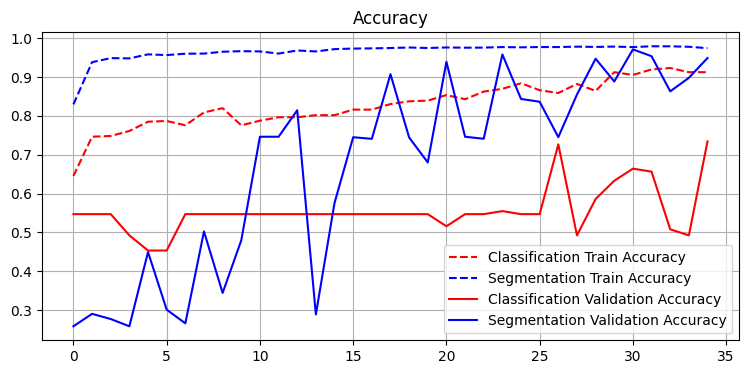

In [ ]:
#Tercera iteración
add_epochs = 15
epochs = total_epochs + add_epochs
initial_epoch = total_epochs

history = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
)

total_epochs += add_epochs

model.save("./model-it-03.h5")
addHistory(history)

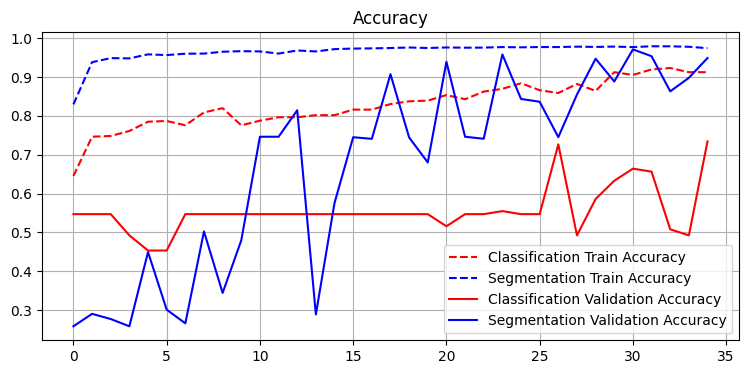

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


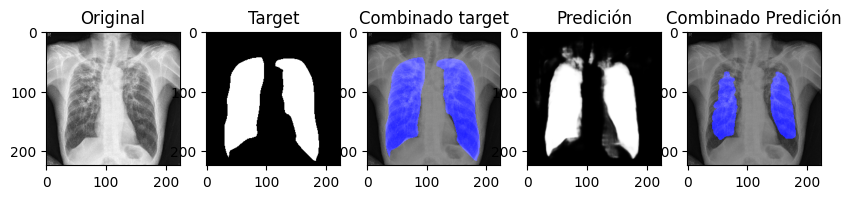

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


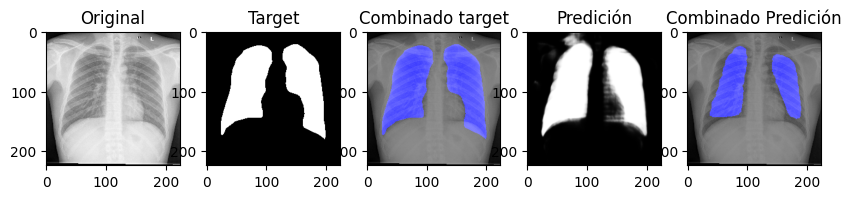

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


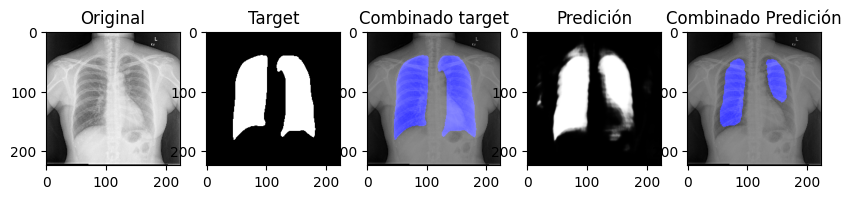

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


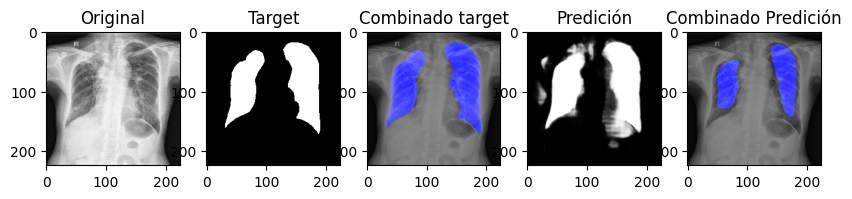

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


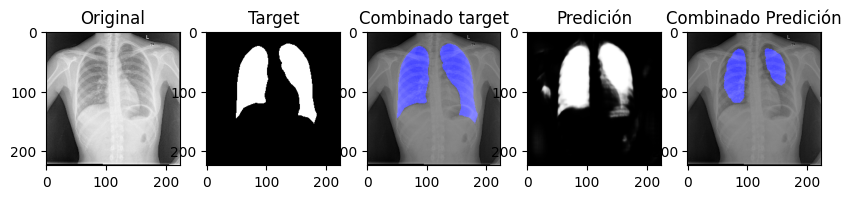

In [ ]:
showCompleteHistory()
view_val_examples(model,5)

In [ ]:
#Cuarta iteración
add_epochs = 15
epochs = total_epochs + add_epochs
initial_epoch = total_epochs

history = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
)

total_epochs += add_epochs

model.save("./model-it-04.h5")
addHistory(history)

Epoch 36/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - classification_accuracy: 0.9275 - classification_loss: 0.1632 - loss: 0.2271 - segmentation_accuracy: 0.9769 - segmentation_loss: 0.0638 - val_classification_accuracy: 0.5469 - val_classification_loss: 2.0746 - val_loss: 2.1876 - val_segmentation_accuracy: 0.9559 - val_segmentation_loss: 0.1130
Epoch 37/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.9318 - classification_loss: 0.1701 - loss: 0.2271 - segmentation_accuracy: 0.9789 - segmentation_loss: 0.0569 - val_classification_accuracy: 0.7344 - val_classification_loss: 1.0960 - val_loss: 1.4522 - val_segmentation_accuracy: 0.9088 - val_segmentation_loss: 0.3562
Epoch 38/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.9430 - classification_loss: 0.1432 - loss: 0.2022 - segmentation_accuracy: 0.9782 - segmentation_loss: 0.0590 - val_classification_accuracy: 0.5938 - val_classification_loss: 2.2944 - val_loss: 2.4272 - val_segmentation_a

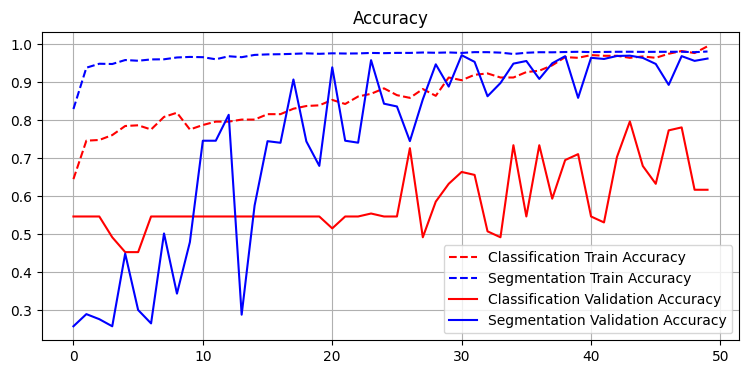

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


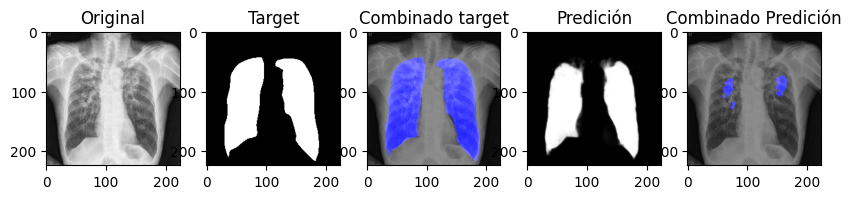

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


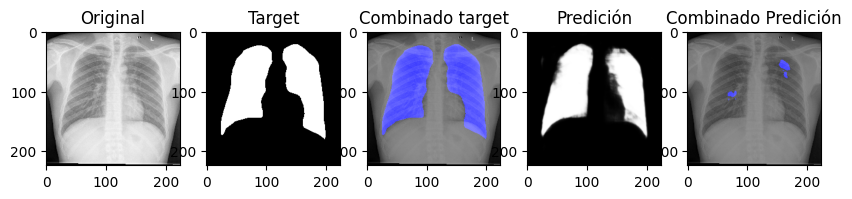

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


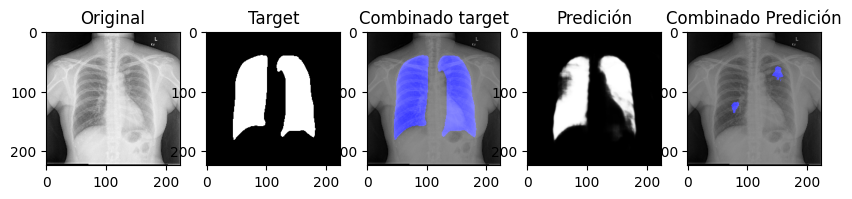

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


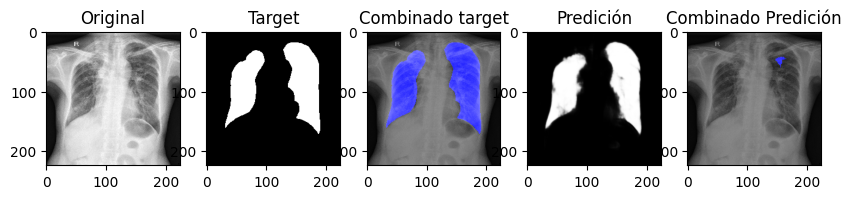

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


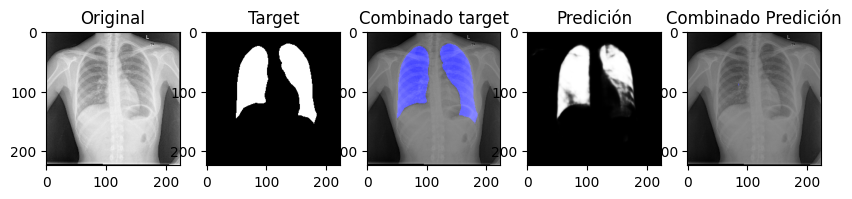

In [ ]:
showCompleteHistory()
view_val_examples(model,5)

##Conclusiones

Es interesante ver como ambas curvas de aprendizaje tienen fluctuaciones que en algunos casos son proporcionalmente opuestas, cuando mejora mucho el nivel de confianza de una, la otra tiene un salto abrupto en sentido contrario y viceversa.
Aun así, se puede apreciar, que tienen una tendencia a una pendiente positiva, pero muy inestable.
Por otro lado, se cree que esta estabilidad se puede mejorar con un planificador, que regule cada cierto nivel de épocas, el peso de cada uno de los errores.

